In [1]:
!pip install transformers trl rouge bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━

In [2]:
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.0 MB/s eta 0:00:00


In [3]:
!python -m spacy download de_core_news_sm

2023-12-22 11:49:44.314996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 11:49:44.315068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 11:49:44.316949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 11:49:44.328051: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 11:49:46.003496: W tensorflow/comp

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer,AutoModelWithLMHead,GPT2Model,TrainingArguments, pipeline
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from google.colab import drive
import pandas as pd
import random
import math
import torch
import re
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score
import matplotlib.pyplot as plt
from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords
from rouge import Rouge
import textstat
import de_core_news_sm
import gensim.corpora as corpora
import gensim
from gensim.models import CoherenceModel
import string
import torch.nn.functional as F
import spacy
from collections import Counter


nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('german')
german_stop_words = set(stopwords.words('german'))
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [5]:
sentiment_pipe_kwargs = {"top_k": None, "function_to_apply": "none"}
classifier = pipeline("sentiment-analysis", model="/content/drive/MyDrive/Masterthesis/Models/sentiment_discriminator_bert_finetuned",**sentiment_pipe_kwargs)


In [6]:
def convert_sentiment(text):
  if text in["[negative]","NEGATIVE"]:
    return 0
  if text in ["[positive]","POSITIVE"]:
    return 1

def convert_to_sentiment(x):
  if x == 0:
    return "[negative]"
  if x==1:
    return "[positive]"

In [7]:
def take_10_words(text):
  words = text.split()[:10]
  return " ".join(words)


In [8]:
def calculate_bleu_score(row):
    reference = row['org_text']
    hypothesis = row['text']

    reference = reference.split()
    hypothesis = hypothesis.split()

    # Calculate the BLEU score
    bleu_score = sentence_bleu([reference], hypothesis)
    return bleu_score


In [9]:
def del_stop_words(text):
  words = nltk.word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in german_stop_words]
  return' '.join(filtered_words)

In [10]:

def calculate_rouge_score(row):
    reference = str(row['org_text'])
    hypothesis = str(row['text'])

    rouge = Rouge()
    scores = rouge.get_scores(hypothesis, reference)
    # Calculate the BLEU score

    return scores[0]["rouge-1"]["f"]

In [11]:
nlp = spacy.load("de_core_news_sm")

def slor_score(text):
  text=text.lstrip()
  slor_scores=[]
  doc = nlp(text)

  # Extract sentences
  sentences = [sent.text for sent in doc.sents]
  # Calculate word frequencies
  for sentence in sentences:

    tokenized_input = tokenizer_ref.encode(sentence, return_tensors="pt",truncation=True)
    sentence_length = len(tokenized_input[0])

    loss, logits = model_ref(tokenized_input, labels=tokenized_input)[:2]
    softmax = torch.nn.Softmax(dim=-1)
    probabilities = softmax(logits)[0]

  # Calculate sentence probability by multiplying token probabilities
    sentence_probability = 1.0
    for token_probability in probabilities:
      max_token_probability = token_probability.max().item()
      sentence_probability *= max_token_probability

    words = re.findall(r'\b\w+\b', sentence.lower())
    word_frequencies = Counter(words)
    total_words = len(words)

    # Calculate probabilities for each word
    word_probabilities = {word: count / total_words for word, count in word_frequencies.items()}

    # Display probabilities for each word
    unigram=1
    for word, prob in word_probabilities.items():
        unigram=unigram*prob
    if total_words!=0:
      slor=math.log(sentence_probability)/total_words-math.log(unigram)/total_words
      slor_scores.append(slor)

  return np.mean(slor_scores)

In [12]:
def lda_coherence_score(text):
    stop_words = set(stopwords.words('german'))
    data_words = nltk.word_tokenize(text, language='german')
    data_words = [word for word in data_words if word.lower() not in stop_words]

    bigrams = gensim.models.Phrases([data_words], min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigrams)
    data_bigrams = [bigram_mod[data_words]]

    nlp = spacy.load("de_core_news_sm", disable=['parser', 'ner'])
    data_lemmatized = [
        [token.lemma_ for token in nlp(word)] for word in data_bigrams[0]
    ]

    id_to_word = corpora.Dictionary(data_lemmatized)
    corpus = [id_to_word.doc2bow(text) for text in data_lemmatized]

    lda_model = gensim.models.LdaModel(corpus=corpus,
                                            id2word=id_to_word,
                                            num_topics=4,
                                            random_state=100,
                                            chunksize=100,
                                            passes=20,
                                            per_word_topics=True)

    coherence_model = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id_to_word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    return coherence_score

In [13]:
def generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,iterations):
  df=pd.DataFrame(columns=["sentiment","text","org_text","perplexity","sent_predicted_label","sent_predicted_score","sentiment_conv","sent_predicted_label_conv"])

  generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 0.5,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
    "eos_token_id": -1,
   # "num_beams":3
  }

  for i in range(iterations):
    prompt=data_sampled.loc[i,"instruction"]
    #prompt_sent=random.sample(sentiment,1)[0]
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(input_ids, **generation_kwargs)
    generated_text = tokenizer.decode(output[0])
    generated_text=re.sub(r'\[.*?\]', '', generated_text)


    tokenize_input = tokenizer_for_perplex.tokenize(generated_text)
    tensor_input = torch.tensor([tokenizer_for_perplex.convert_tokens_to_ids(tokenize_input)])
    loss, logits = model_for_perplex(tensor_input, labels=tensor_input)[:2]

    df.loc[i,"sentiment"]=data_sampled.loc[i,"sent_str"]
    df.loc[i,"text"]=generated_text
    df.loc[i,"org_text"]=data_sampled.loc[i,"preprocessed_text"]
    df.loc[i,"perplexity"]=math.exp(loss)
    df.loc[i,"perplexity"]=df.loc[i,"perplexity"]#.astype(float)
    pred=classifier(generated_text)
    df.loc[i,"sent_predicted_label"]=pred[0][0]["label"]
    df.loc[i,"sent_predicted_score"]=pred[0][0]["score"]
    df.loc[i,'sentiment_conv']=convert_sentiment(df.loc[i,"sentiment"])
    df.loc[i,'sent_predicted_label_conv']=convert_sentiment(df.loc[i,"sent_predicted_label"])
    df.loc[i,'text_del_stop_words']=del_stop_words(df.loc[i,'text'])

  return df

In [14]:
def evaluation(data):

  data["slor"]=data["text"].apply(slor_score)
  print("Mean SLOR: ", np.mean(data["slor"]))


  data["readability_score"]=data["text"].apply(textstat.flesch_reading_ease)
  print("Mean FRE: ", np.mean(data["readability_score"]))

  data['text_processed'] = data['text'].map(lambda x: x.lower()).map(lambda x: re.sub('[,\.!?]', '', x))
  data['lda_score']=data['text_processed'].apply(lda_coherence_score)
  print("Mean Coherence: ", np.mean(data["lda_score"]))

  print("Mean Perplexity: ", np.mean(data["perplexity"]))
  y_test=list(data["sentiment_conv"])
  predicted=list(data["sent_predicted_label_conv"])

  cm=confusion_matrix(y_test, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

  cm_display.plot()
  plt.show()

  accuracy = accuracy_score(y_test, predicted)
  print("Sentiment accuracy:", accuracy)

  # Calculate recall
  recall = recall_score(y_test, predicted,average=None)
  print("Sentiment recall:", recall.mean())

  # Calculate precision
  precision = precision_score(y_test, predicted,average=None)
  print("Sentiment precision:", precision.mean())

  f1 = f1_score(y_test, predicted,average=None)
  print("F1 score:", f1.mean())
  data['rouge_score_f'] = data.apply(calculate_rouge_score, axis=1)
  print("Rouge score: ",data['rouge_score_f'].mean())

In [15]:
def bert_modeling(docs):
  topic_model = BERTopic(language="multilingual")
  topics, probs = topic_model.fit_transform(docs)

  print("Topic Info:")
  print(topic_model.get_topic_info())

  print("Get Topics")
  print(topic_model.get_topics())


In [16]:
 path="/content/drive/MyDrive/Masterthesis/Data/data_processed/test_for_sft.tsv"
 data_rl=pd.read_csv(path, sep='\t')
 data_rl["sent_str"]=data_rl.sentiment.apply(convert_to_sentiment)
 data_rl["seq_start"]=data_rl.preprocessed_text.apply(take_10_words)
 data_rl["instruction"]=data_rl["sent_str"]+" "+data_rl["seq_start"]

In [17]:
positive_samples = data_rl[data_rl['sentiment'] == 1]
negative_samples = data_rl[data_rl['sentiment'] == 0]
sampled_positive = positive_samples.sample(n=50, random_state=123)
sampled_negative = negative_samples.sample(n=50, random_state=123)
data_sampled = pd.concat([sampled_positive, sampled_negative])
data_sampled=data_sampled.sample(frac=1, random_state=42)
data_sampled=data_sampled.reset_index()


In [18]:
tokenizer_for_perplex = AutoTokenizer.from_pretrained("distilbert-base-german-cased")
model_for_perplex = AutoModelWithLMHead.from_pretrained("distilbert-base-german-cased")


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/479k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/270M [00:00<?, ?B/s]

In [19]:
tokenizer_ref = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
model_ref = AutoModelWithLMHead.from_pretrained("dbmdz/bert-base-german-cased")
tokenizer_ref.pad_token = tokenizer_ref.eos_token
global tokenizer_ref
global model_ref

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Testing of original GPT

In [20]:
tokenizer = AutoTokenizer.from_pretrained("benjamin/gpt2-wechsel-german")
model = AutoModelWithLMHead.from_pretrained("benjamin/gpt2-wechsel-german")
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/856k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/514k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/665M [00:00<?, ?B/s]

In [24]:
df_gpt=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,1)

In [ ]:
evaluation(df_gpt)

In [ ]:
df_gpt.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_GPT_org_longer.tsv", sep="\t")

Mean SLOR:  1.110557875050443
Mean FRE:  75.76570000000001
Mean Coherence:  0.863449721533332
Mean Perplexity:  1.115146638553374


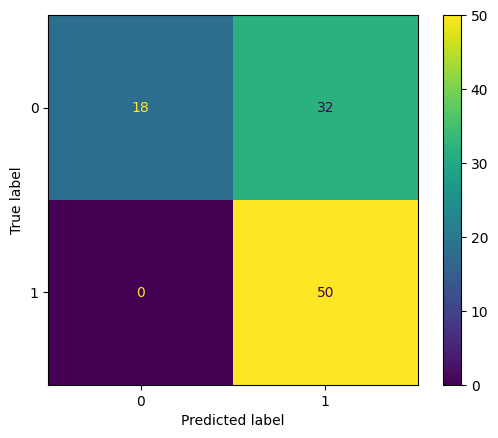

Sentiment accuracy: 0.68
Sentiment recall: 0.6799999999999999
Sentiment precision: 0.8048780487804879
F1 score: 0.6434937611408199
Rouge score:  0.2916183739968673


In [23]:
df_gpt=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_GPT_org_longer.tsv", sep="\t")
evaluation(df_gpt)

In [ ]:
bert_modeling(df_gpt['text_del_stop_words'])


Topic Info:
   Topic  Count                        Name  \
0     -1    100  -1_gut_hotel_sauber_zimmer   

                                      Representation  \
0  [gut, hotel, sauber, zimmer, freundlich, lage,...   

                                 Representative_Docs  
0  [Grandiose Aussicht toller Service Insgesamt t...  
Get Topics
{-1: [('gut', 0.12065265147566824), ('hotel', 0.10197264634537553), ('sauber', 0.09426803781266109), ('zimmer', 0.09295464072608357), ('freundlich', 0.07644863194504295), ('lage', 0.0629893498902561), ('personal', 0.0629893498902561), ('frühstück', 0.05084433747180011), ('hilfsbereit', 0.04568778327355162), ('schön', 0.041233118653906414)]}


0     Zimmermädchen Bedienungen Restaurant nett zuvo...
1     Sportangebot außer immer 13.00Uhr Pool Ärobic ...
2     eigtl wenig Deutsch gesprochen . viele versteh...
3     Wunderschöner Urlaub , kommen freundlich einge...
4     Animationen tagsüber gesucht Glück gefunden . ...
                            ...                        
95    Luxuszimmer , Klimaanlage , schlafen langt . G...
96    Ankunft sah Badezimmer viele Haare , Menge Sch...
97    Toller Urlaub Hotel schön , sauber gepflegt . ...
98    empfehlenswert ! Schlechtes Essen ! Service Re...
99    gesagt , Frühstücksbedienung unfreundlich , vi...
Name: text_del_stop_words, Length: 100, dtype: object

# Testing of models after supervised fine-tuning
## GPT-2 trained one epoch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_1_epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_1_epochs")
tokenizer.pad_token = tokenizer.eos_token


In [ ]:
df_sft_1=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,100)

In [ ]:
#df_sft_1.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_longer.tsv", sep="\t")

In [ ]:
df_sft_1=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_longer.tsv", sep="\t")

Mean SLOR:  1.046170042532423
Mean FRE:  79.9064
Mean Coherence:  0.8630368705696904
Mean Perplexity:  1.124396486036651


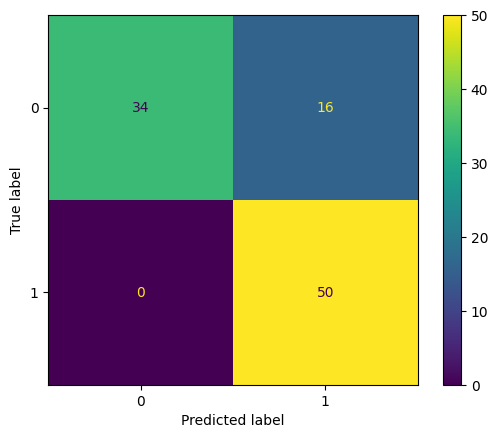

Sentiment accuracy: 0.84
Sentiment recall: 0.8400000000000001
Sentiment precision: 0.8787878787878788
F1 score: 0.8357963875205254
Rouge score:  0.2987514231515142


In [ ]:
evaluation(df_sft_1)

In [ ]:
bert_modeling(df_sft_1['text_del_stop_words'])


.gitattributes:   0%|          | 0.00/968 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Topic Info:
   Topic  Count                       Name  \
0     -1     10  -1_immer_ca_flughafen_gut   
1      0     72   0_hotel_sauber_gut_essen   
2      1     18  1_zimmer_bad_klein_betten   

                                      Representation  \
0  [immer, ca, flughafen, gut, hotel, gibt, käse,...   
1  [hotel, sauber, gut, essen, gab, strand, perso...   
2  [zimmer, bad, klein, betten, gewechselt, dusch...   

                                 Representative_Docs  
0  [Hotel günstige Lage Flughafen , Fahrt daürt e...  
1  [Toller Urlaub Hotel schön , sauber gepflegt ....  
2  [Zimmer normal groß , Einrichtung alt abgewohn...  
Get Topics
{-1: [('immer', 0.12449151861006602), ('ca', 0.09852538465160494), ('flughafen', 0.0849114530681639), ('gut', 0.08164199114713531), ('hotel', 0.07938761713294618), ('gibt', 0.07395662359206662), ('käse', 0.07077748837610402), ('wurde', 0.07076968097540788), ('gab', 0.07066270708185336), ('spiegelei', 0.06267998331772653)], 0: [('hotel', 0.084621

##GPT-2 trained two epochs

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_2_epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_2_epochs")
tokenizer.pad_token = tokenizer.eos_token


In [ ]:
df_sft_2=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,100)


In [ ]:
#df_sft_2.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_longer.tsv", sep="\t")

In [ ]:
df_sft_2=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_longer.tsv", sep="\t")


Mean SLOR:  1.0796542108706249
Mean FRE:  79.8778
Mean Coherence:  0.8641129772973595
Mean Perplexity:  1.1329989299184104


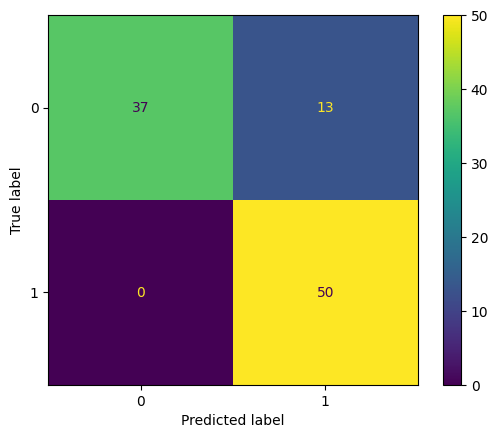

Sentiment accuracy: 0.87
Sentiment recall: 0.87
Sentiment precision: 0.8968253968253967
F1 score: 0.8677652324280338
Rouge score:  0.30411446102251094


In [ ]:
evaluation(df_sft_2)

In [ ]:
bert_modeling(df_sft_2['text_del_stop_words'])

Topic Info:
   Topic  Count                              Name  \
0     -1      1       -1_mehr_essen_bad_schamhaar   
1      0     83          0_hotel_strand_gut_essen   
2      1     16  1_zimmer_klimaanlage_safe_betten   

                                      Representation  \
0  [mehr, essen, bad, schamhaar, alkohol, mittag,...   
1  [hotel, strand, gut, essen, sauber, immer, per...   
2  [zimmer, klimaanlage, safe, betten, balkon, au...   

                                 Representative_Docs  
0  [Lage top , ansonsten flop ! Zimmer ekelhaft d...  
1  [Hause gefühlt . Super Urlaub ! Danke ! Hammer...  
2  [Zimmer schön groß sauber . Badewanne klein , ...  
Get Topics
{-1: [('mehr', 0.2645249822888781), ('essen', 0.18762134102012995), ('bad', 0.17860927029807724), ('schamhaar', 0.14575121280619446), ('alkohol', 0.14575121280619446), ('mittag', 0.14575121280619446), ('kindermenü', 0.14575121280619446), ('kaltes', 0.14575121280619446), ('ekelhaft', 0.14575121280619446), ('fettiges', 

##GPT-2 trained three epochs


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_3_epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_with_tokens_big_3_epochs")
tokenizer.pad_token = tokenizer.eos_token


In [ ]:
df_sft_3=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,100)

In [ ]:
#df_sft_3.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_3_longer.tsv", sep="\t")

In [ ]:
df_sft_3=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_3_longer.tsv", sep="\t")

Mean SLOR:  1.0958362196293967
Mean FRE:  78.6079
Mean Coherence:  0.8635499540599835
Mean Perplexity:  1.1249397338686595


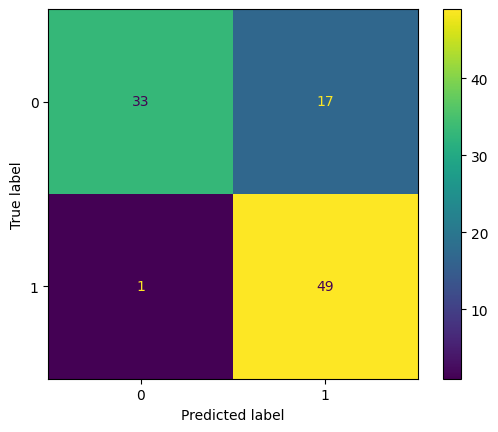

Sentiment accuracy: 0.82
Sentiment recall: 0.8200000000000001
Sentiment precision: 0.85650623885918
F1 score: 0.8152709359605911
Rouge score:  0.29824530654317594


In [ ]:
evaluation(df_sft_3)

In [ ]:
bert_modeling(df_sft_3['text_del_stop_words'])

Topic Info:
   Topic  Count                             Name  \
0     -1     34         -1_eis_immer_super_danke   
1      0     29      0_hotel_strand_sauber_schön   
2      1     23    1_essen_hotel_schlecht_leider   
3      2     14  2_zimmer_tag_klimaanlage_wurden   

                                      Representation  \
0  [eis, immer, super, danke, freundlich, gibt, h...   
1  [hotel, strand, sauber, schön, gepflegt, freun...   
2  [essen, hotel, schlecht, leider, unfreundlich,...   
3  [zimmer, tag, klimaanlage, wurden, betten, ger...   

                                 Representative_Docs  
0  [Wunderschöner Urlaub , kommen freundlich eing...  
1  [Gutes Hotel guter Lage Toller Badeurlaub . Ho...  
2  [frühstück gebucht besser sodas abendessen lei...  
3  [Zimmer schön groß sauber . Badewanne Duschvor...  
Get Topics
{-1: [('eis', 0.06876490954320133), ('immer', 0.06263119708849334), ('super', 0.052807175617919484), ('danke', 0.0500832393031087), ('freundlich', 0.04572559392

#After RL
## GPT finetuned SFT for 1 epoch
### RL 1 Epoch
(apricot-thunder-92)



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_1epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_1epochs")
tokenizer.pad_token = tokenizer.eos_token


Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_1epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.weight', 'v_head.summary.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_1_rl_1=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,100)


In [ ]:
#df_sft_1_rl_1.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_rl_1_longer.tsv", sep="\t")

In [ ]:
df_sft_1_rl_1=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_rl_1_longer.tsv", sep="\t")

Mean SLOR:  0.9645056365104776
Mean FRE:  79.4986
Mean Coherence:  0.8639004312892162
Mean Perplexity:  1.1199217623655742


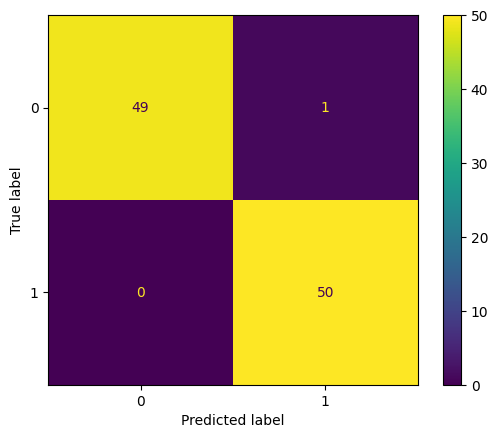

Sentiment accuracy: 0.99
Sentiment recall: 0.99
Sentiment precision: 0.9901960784313726
F1 score: 0.98999899989999
Rouge score:  0.30721062502218305


In [ ]:
evaluation(df_sft_1_rl_1)

In [ ]:
bert_modeling(df_sft_1_rl_1['text_del_stop_words'])

Topic Info:
   Topic  Count                                   Name  \
0     -1      5             -1_telefon_safe_minibar_tv   
1      0     52        0_gut_freundlich_hotel_personal   
2      1     43  1_schlecht_essen_unfreundlich_dreckig   

                                      Representation  \
0  [telefon, safe, minibar, tv, kühlschrank, zimm...   
1  [gut, freundlich, hotel, personal, hilfsbereit...   
2  [schlecht, essen, unfreundlich, dreckig, gab, ...   

                                 Representative_Docs  
0  [Zimmer groß , gut ausgestattet sauber . gab K...  
1  [schönes Hotel schon zweite mal kommen . Perso...  
2  [Urlaub Baustelle Renovierungsarbeiten Gäste Z...  
Get Topics
{-1: [('telefon', 0.48195053524868836), ('safe', 0.3913248674927784), ('minibar', 0.3140853600740131), ('tv', 0.23640924523543824), ('kühlschrank', 0.19877786004043735), ('zimmer', 0.16381932761591284), ('klimaanlage', 0.15775722634866926), ('kleinen', 0.1521057635314778), ('sauber', 0.124755696513

### RL 2 Epochs

(floral-cosmos-97)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_2epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_2epochs")
tokenizer.pad_token = tokenizer.eos_token


Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_1_epoch_rl_2epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.weight', 'v_head.summary.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_1_rl_2=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,100)


In [ ]:
#df_sft_1_rl_2.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_rl_2_longer.tsv", sep="\t")

In [ ]:
df_sft_1_rl_2=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_1_rl_2_longer.tsv", sep="\t")

Mean SLOR:  0.9946805911058757
Mean FRE:  81.4764
Mean Coherence:  0.8660099248267025
Mean Perplexity:  1.1201171936351317


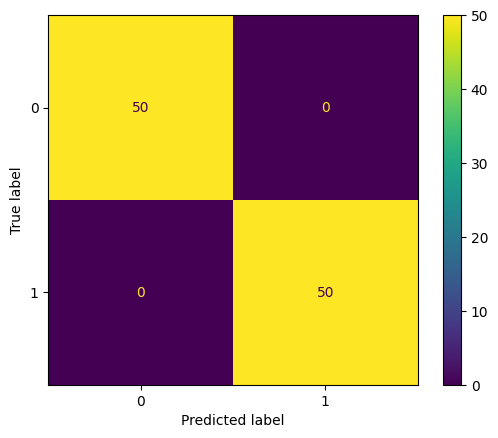

Sentiment accuracy: 1.0
Sentiment recall: 1.0
Sentiment precision: 1.0
F1 score: 1.0
Rouge score:  0.3168067882756343


In [ ]:
evaluation(df_sft_1_rl_2)

In [ ]:
bert_modeling(df_sft_1_rl_2['text_del_stop_words'])

Topic Info:
   Topic  Count                           Name  \
0      0     53   0_gut_zimmer_sauber_personal   
1      1     47  1_dreckig_zimmer_schlecht_gab   

                                      Representation  \
0  [gut, zimmer, sauber, personal, freundlich, es...   
1  [dreckig, zimmer, schlecht, gab, unfreundlich,...   

                                 Representative_Docs  
0  [Super Urlaub Halbpension doll . Tag gleiche l...  
1  [Hotel Club Calimera Hurghada wurden Hotel sch...  
Get Topics
{0: [('gut', 0.16268192924881714), ('zimmer', 0.13732902270585176), ('sauber', 0.12662142725064118), ('personal', 0.11733656847942198), ('freundlich', 0.09926348299697603), ('essen', 0.08535001261553271), ('schön', 0.08435776395522557), ('hotel', 0.08284692738101757), ('immer', 0.08208655705247755), ('hilfsbereit', 0.06448097216691043)], 1: [('dreckig', 0.10869464155145782), ('zimmer', 0.09624513949167639), ('schlecht', 0.08816265949629161), ('gab', 0.08442569745275814), ('unfreundlich',

## GPT finetuned SFT for 2 epoch
### RL 1 Epoch

fine-feather-100



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_1epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_1epochs")
tokenizer.pad_token = tokenizer.eos_token


Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_1epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.weight', 'v_head.summary.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_2_rl_1=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,100)


In [ ]:
#df_sft_2_rl_1.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_rl_1_longer.tsv", sep="\t")

In [ ]:
df_sft_2_rl_1=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_rl_1_longer.tsv", sep="\t")

Mean SLOR:  0.9646878708872572
Mean FRE:  75.3697
Mean Coherence:  0.8647585782637435
Mean Perplexity:  1.120310136148516


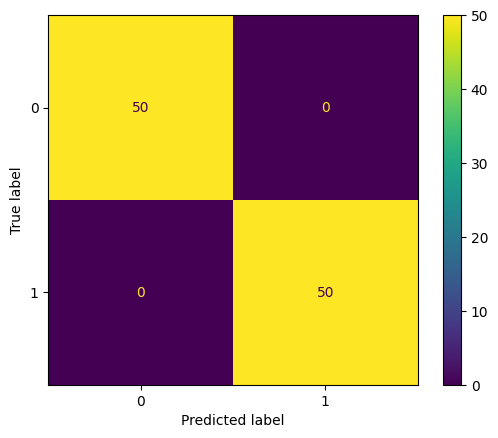

Sentiment accuracy: 1.0
Sentiment recall: 1.0
Sentiment precision: 1.0
F1 score: 1.0
Rouge score:  0.30827282585682236


In [ ]:
evaluation(df_sft_2_rl_1)

In [ ]:
bert_modeling(df_sft_2_rl_1['text_del_stop_words'])

Topic Info:
   Topic  Count                                   Name  \
0      0     56               0_gut_immer_strand_essen   
1      1     44  1_dreckig_gewechselt_unfreundlich_gab   

                                      Representation  \
0  [gut, immer, strand, essen, sauber, hotel, per...   
1  [dreckig, gewechselt, unfreundlich, gab, wurde...   

                                 Representative_Docs  
0  [Toller Urlaub Hotel schön , sauber gepflegt ....  
1  [Nie Hotel Playamar ! Woche Hotel . Zimmer dre...  
Get Topics
{0: [('gut', 0.12625069143723186), ('immer', 0.10259365913968453), ('strand', 0.09757328134618515), ('essen', 0.0972997987145753), ('sauber', 0.09504556300279093), ('hotel', 0.09393428355906314), ('personal', 0.08295069441534489), ('gutes', 0.08284969313151842), ('freundlich', 0.08207163851083107), ('super', 0.08179844279387412)], 1: [('dreckig', 0.19463472609068505), ('gewechselt', 0.10487096274217295), ('unfreundlich', 0.1011369549643623), ('gab', 0.092251786083

## RL 2


vital-lion-101



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_2epochs")
model = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_2epochs")
tokenizer.pad_token = tokenizer.eos_token



Some weights of the model checkpoint at /content/drive/MyDrive/Masterthesis/Models/german_gpt2_sft_2_epoch_rl_2epochs were not used when initializing GPT2LMHeadModel: ['v_head.summary.weight', 'v_head.summary.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_sft_2_rl_2=generation(data_sampled, tokenizer,tokenizer_for_perplex, model, model_for_perplex,100)

In [ ]:
#df_sft_2_rl_2.to_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_rl_2_longer.tsv", sep="\t")

Mean SLOR:  0.8693113910257232
Mean FRE:  79.307
Mean Coherence:  0.8639540989732357
Mean Perplexity:  1.1119660795655646


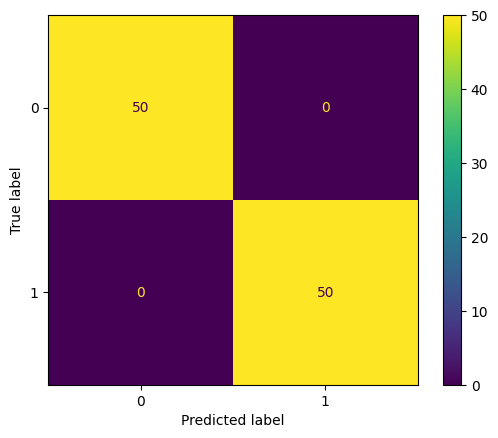

Sentiment accuracy: 1.0
Sentiment recall: 1.0
Sentiment precision: 1.0
F1 score: 1.0
Rouge score:  0.3077771948967199


In [ ]:
evaluation(df_sft_2_rl_2)

In [ ]:
df_sft_2_rl_2=pd.read_csv("/content/drive/MyDrive/Masterthesis/Results/Evaluation_df_sft_2_rl_2_longer.tsv", sep="\t")

Mean SLOR:  0.8693090729379628
Mean FRE:  79.307
Mean Coherence:  0.8639540989732357
Mean Perplexity:  1.1119660795655646


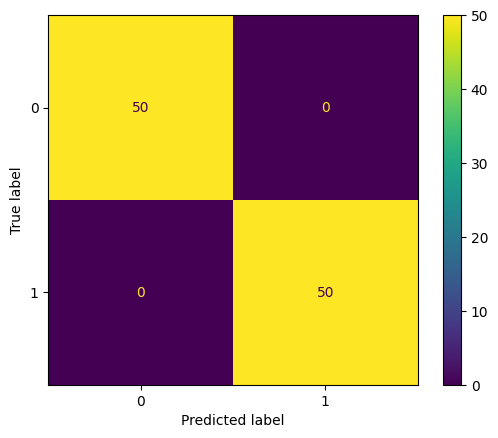

Sentiment accuracy: 1.0
Sentiment recall: 1.0
Sentiment precision: 1.0
F1 score: 1.0
Rouge score:  0.3077771948967199


In [ ]:
evaluation(df_sft_2_rl_2)

In [ ]:
bert_modeling(df_sft_2_rl_2['text_del_stop_words'])

Topic Info:
   Topic  Count                                   Name  \
0      0     56               0_gut_immer_strand_essen   
1      1     44  1_dreckig_gewechselt_unfreundlich_gab   

                                      Representation  \
0  [gut, immer, strand, essen, sauber, hotel, per...   
1  [dreckig, gewechselt, unfreundlich, gab, wurde...   

                                 Representative_Docs  
0  [Toller Urlaub Hotel schön , sauber gepflegt ....  
1  [Nie Hotel Playamar ! Woche Hotel . Zimmer dre...  
Get Topics
{0: [('gut', 0.12625069143723186), ('immer', 0.10259365913968453), ('strand', 0.09757328134618515), ('essen', 0.0972997987145753), ('sauber', 0.09504556300279093), ('hotel', 0.09393428355906314), ('personal', 0.08295069441534489), ('gutes', 0.08284969313151842), ('freundlich', 0.08207163851083107), ('super', 0.08179844279387412)], 1: [('dreckig', 0.19463472609068505), ('gewechselt', 0.10487096274217295), ('unfreundlich', 0.1011369549643623), ('gab', 0.092251786083